In [4]:
using Distributed
# Script for investigating amplitude dependence of potential
@everywhere using Distributions
@everywhere using StatsBase
@everywhere using LinearAlgebra
@everywhere using LaTeXStrings
using BenchmarkTools
using Test
using Dates
using Primes
using MCMCDiagnostics
using SharedArrays
using DelimitedFiles

@everywhere struct Hack end
function fixRC()
    for p in workers()
        @fetchfrom p Hack()
    end
end
fixRC()

src_path = "/home/nicolai/Documents/Work/PhD/Numerikk/MC/finite-temp-vortex-lattice/Source/Grid/"
@everywhere push!(LOAD_PATH, $src_path)
@everywhere using CuboidModule

@everywhere src_path = "../Source/Grid/"
@everywhere include(src_path*"observables.jl")
@everywhere include(src_path*"utilities.jl")
include(src_path*"plot_functions.jl")

@everywhere src_path = "../Source/"
@everywhere include(src_path*"jackknife_estimates.jl")

using Plots
pyplot()

Plots.PyPlotBackend()

In [5]:
using JLD

# Exploring results

#### Navigating to folder

In [6]:
pwd()

"/home/nicolai/Documents/Work/PhD/Numerikk/MC/finite-temp-vortex-lattice/Notebooks"

In [7]:
cd("../Scripts/full_model_L=32_T=2.0_g=0.316_fL=1.0_stepwise_cool/")

#### Energy

In [8]:
ens_di = JLD.load("energies.jld")
E_by_T = ens_di["E_by_T"]
size(E_by_T[1], 1)

8192

In [9]:
meta_di = JLD.load("meta.jld")
f = meta_di["f"]; L₃ = meta_di["L3"]; M = meta_di["M"]; temps = meta_di["temps"]; κ₅ = meta_di["kappa"];
Δt = meta_di["dt"]; L₁ = meta_di["L1"]; L₂ = meta_di["L2"]; g = meta_di["g"]; ν = meta_di["nu"]
M_amp = meta_di["M_amp"];
println("fL₁ = $(f*L₁), L₁ = $(L₁), L₂ = $(L₂), L₃ = $(L₃), g = $(g)\nT = $(temps)")

fL₁ = 1.0, L₁ = 32, L₂ = 32, L₃ = 32, g = 0.316227766
T = [2.0]


In [10]:
N = L₁*L₂*L₃;
N_T = length(temps)

1

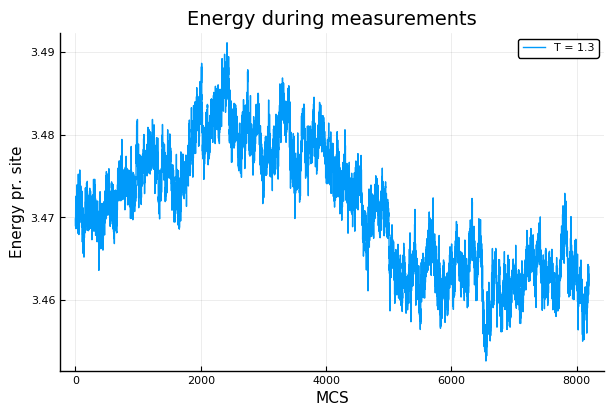

In [12]:
plt = plot(E_by_T./N; label=reshape(["T = $(round(T, digits=2))" for T in temps], 1, N_T),
    xaxis="MCS", yaxis="Energy pr. site", title="Energy during measurements")
savefig(plt, "measure_energies.pdf")

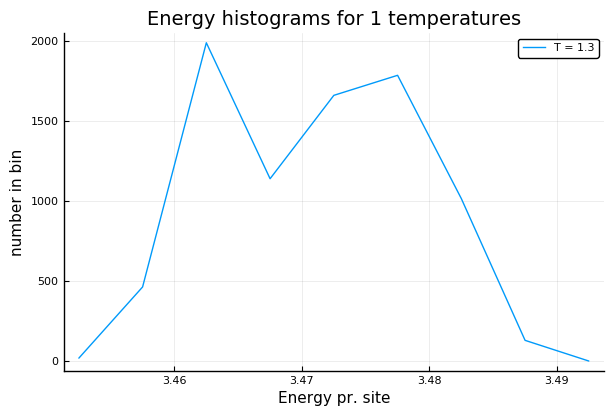

In [16]:
# Plot energy histograms
plotEnergyHistograms(E_by_T./N, temps);

In [14]:
therm_di = JLD.load("thermalization.jld")
M_th = therm_di["M_th"]
M_est = therm_di["M_est"]
M_col = therm_di["M_col"]
E_therm = therm_di["e_thm"];

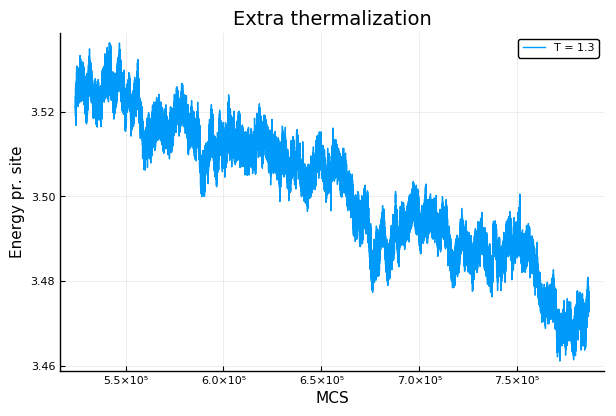

In [15]:
int = 1:size(E_therm, 1)#floor(Int64, M_th/2)
therm_plt = plot(collect(int).+M_est.+M_col, [E_therm[int, i] for i = 1:N_T]; 
                 label=reshape(["T = $(round(T; digits=2))" for T in temps], (1, N_T)),
                 xaxis="MCS", yaxis="Energy pr. site", title="Extra thermalization")
savefig(therm_plt, "thermalization energies.pdf")

#### Dual Stiffness

In [17]:
dual_di = JLD.load("dual_stiffs.jld");
ρˣ₂_by_T = dual_di["x2"]
ρˣ₃_by_T = dual_di["x3"]
ρʸ₁_by_T = dual_di["y1"]
ρʸ₃_by_T = dual_di["y3"]
ρᶻ₁_by_T = dual_di["z1"]
ρᶻ₂_by_T = dual_di["z2"]
length(ρˣ₂_by_T[1])

8192

Plotting some variance graphs and making jackknife estimates

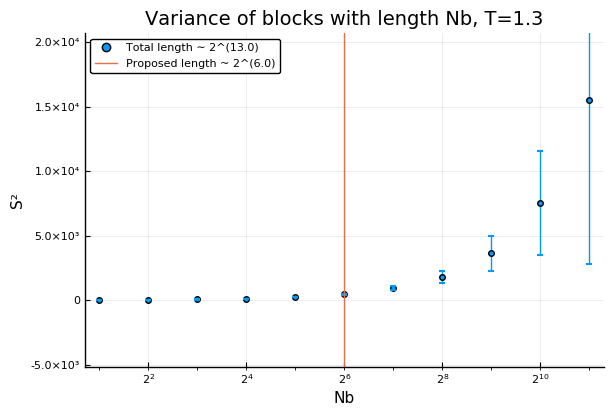

In [18]:
num_blocks = 2^7
varianceByBlockLengthPlots(ρʸ₁_by_T, E_by_T, [1/T for T in temps]; num_blocks=num_blocks)

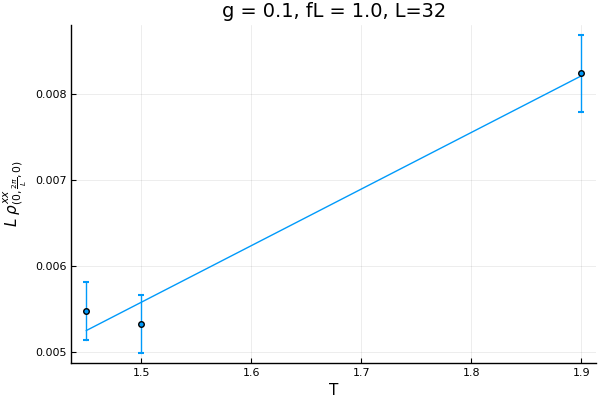

In [17]:
ρˣ₂_avg_by_T = Array{Float64}(undef, N_T); ρˣ₂_err_by_T = Array{Float64}(undef, N_T);
for i = 1:N_T
    jv = jackVars(mean, ρˣ₂_by_T[i], num_blocks; skip_check=true)
    ρˣ₂_avg_by_T[i], var = jackEstimate(jv)
    ρˣ₂_err_by_T[i] = √(var)
end
plt = scatter(temps, L₁.*ρˣ₂_avg_by_T, yerror=L₁.*ρˣ₂_err_by_T; 
    smooth=true, xlabel="T", ylabel=L"L\;\rho^{xx}_{(0, \frac{2\pi}{L}, 0)}", label="",
    title="g = $(round(g; digits=2)), fL = $(round(f*L₁; digits=2)), L=$(L₁)")

Construct jackknife estimates for the rest of the components and save in separate folder

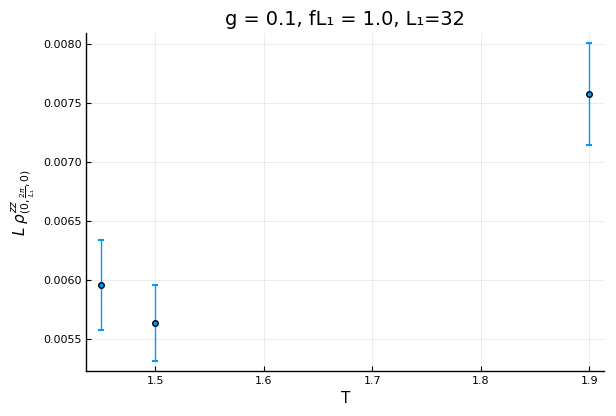

In [18]:
mkcd("dual_gauge_stiffness")
ρˣ₃_avg_by_T = Array{Float64}(undef, N_T); ρˣ₃_err_by_T = Array{Float64}(undef, N_T);
ρˣ₂_avg_by_T = Array{Float64}(undef, N_T); ρˣ₂_err_by_T = Array{Float64}(undef, N_T);
ρʸ₁_avg_by_T = Array{Float64}(undef, N_T); ρʸ₁_err_by_T = Array{Float64}(undef, N_T);
ρʸ₃_avg_by_T = Array{Float64}(undef, N_T); ρʸ₃_err_by_T = Array{Float64}(undef, N_T);
ρᶻ₁_avg_by_T = Array{Float64}(undef, N_T); ρᶻ₁_err_by_T = Array{Float64}(undef, N_T);
ρᶻ₂_avg_by_T = Array{Float64}(undef, N_T); ρᶻ₂_err_by_T = Array{Float64}(undef, N_T);
for k = 1:N_T
    jv_x2 = jackVars(mean, ρˣ₂_by_T[k], num_blocks; skip_check=true)
    jv_x3 = jackVars(mean, ρˣ₃_by_T[k], num_blocks; skip_check=true)
    jv_y1 = jackVars(mean, ρʸ₁_by_T[k], num_blocks; skip_check=true)
    jv_y3 = jackVars(mean, ρʸ₃_by_T[k], num_blocks; skip_check=true)
    jv_z1 = jackVars(mean, ρᶻ₁_by_T[k], num_blocks; skip_check=true)
    jv_z2 = jackVars(mean, ρᶻ₂_by_T[k], num_blocks; skip_check=true)
    
    ρˣ₂_avg_by_T[k], var_x2 = jackEstimate(jv_x2); ρˣ₃_avg_by_T[k], var_x3 = jackEstimate(jv_x3)
    ρʸ₁_avg_by_T[k], var_y1 = jackEstimate(jv_y1); ρʸ₃_avg_by_T[k], var_y3 = jackEstimate(jv_y3)
    ρᶻ₁_avg_by_T[k], var_z1 = jackEstimate(jv_z1); ρᶻ₂_avg_by_T[k], var_z2 = jackEstimate(jv_z2)
    
    ρˣ₂_err_by_T[k] = √(var_x2); ρˣ₃_err_by_T[k] = √(var_x3)
    ρʸ₁_err_by_T[k] = √(var_y1); ρʸ₃_err_by_T[k] = √(var_y3)
    ρᶻ₁_err_by_T[k] = √(var_z1); ρᶻ₂_err_by_T[k] = √(var_z2)
end

plt = scatter(temps, L₁.*ρˣ₂_avg_by_T, yerror=L₁.*ρˣ₂_err_by_T;
    smooth=false, xlabel="T", ylabel=L"L\;\rho^{xx}_{(0, \frac{2\pi}{L₁}, 0)}", label="",
    title="g = $(round(g; digits=2)), fL₁ = $(round(f*L₁; digits=2)), L₁=$(L₁)")
savefig(plt, "gauge_stiff_x2.png")
plt1 = scatter(temps, L₁.*ρˣ₃_avg_by_T, yerror=L₁.*ρˣ₃_err_by_T;
    smooth=false, xlabel="T", ylabel=L"L₁\;\rho^{xx}_{(0, 0, \frac{2\pi}{L₁})}", label="",
    title="g = $(round(g; digits=2)), fL₁ = $(round(f*L₁; digits=2)), L₁=$(L₁)")
savefig(plt1, "gauge_stiff_x3.png")
plt = scatter(temps, L₁.*ρʸ₁_avg_by_T, yerror=L₁.*ρʸ₁_err_by_T;
    smooth=false, xlabel="T", ylabel=L"L\;\rho^{yy}_{(\frac{2\pi}{L₁}, 0, 0)}", label="",
    title="g = $(round(g; digits=2)), fL₁ = $(round(f*L₁; digits=2)), L₁=$(L₁)")
savefig(plt, "gauge_stiff_y1.png")
plt = scatter(temps, L₁.*ρʸ₃_avg_by_T, yerror=L₁.*ρʸ₃_err_by_T;
    smooth=false, xlabel="T", ylabel=L"L\;\rho^{yy}_{(0, 0, \frac{2\pi}{L₁})}", label="",
    title="g = $(round(g; digits=2)), fL₁ = $(round(f*L₁; digits=2)), L₁=$(L₁)")
savefig(plt, "gauge_stiff_y3.png")
plt = scatter(temps, L₁.*ρᶻ₁_avg_by_T, yerror=L₁.*ρᶻ₁_err_by_T;
    smooth=false, xlabel="T", ylabel=L"L\;\rho^{zz}_{(\frac{2\pi}{L₁}, 0, 0)}", label="",
    title="g = $(round(g; digits=2)), fL₁ = $(round(f*L₁; digits=2)), L₁=$(L₁)")
savefig(plt, "gauge_stiff_z1.png")
plt = scatter(temps, L₁.*ρᶻ₂_avg_by_T, yerror=L₁.*ρᶻ₂_err_by_T;
    smooth=false, xlabel="T", ylabel=L"L\;\rho^{zz}_{(0, \frac{2\pi}{L₁}, 0)}", label="",
    title="g = $(round(g; digits=2)), fL₁ = $(round(f*L₁; digits=2)), L₁=$(L₁)")
savefig(plt, "gauge_stiff_z2.png")

cd("../")

#### Specific heat

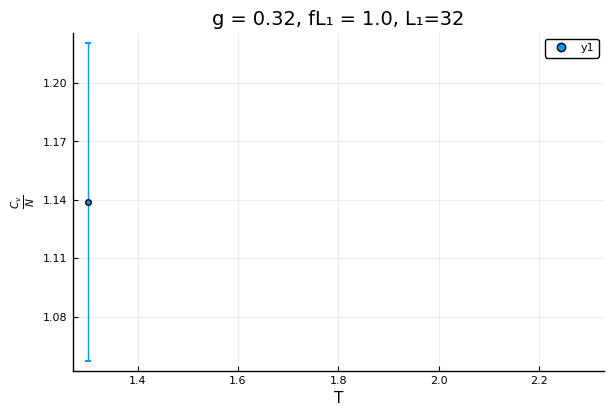

In [19]:
Cv_avg_by_T = Array{Float64, 1}(undef, N_T)
Cv_err_by_T = Array{Float64, 1}(undef, N_T)
for k = 1:N_T
    jv = jackVars(energies -> specificHeat(energies, 1/temps[k]), E_by_T[k], num_blocks; skip_check=true)
    Cv_avg_by_T[k], var = jackEstimate(jv)
    Cv_err_by_T[k] = √(var)
end
plt = scatter(temps, Cv_avg_by_T./N, yerror=Cv_err_by_T./N; ylabel=L"\frac{C_v}{N}", xlabel="T",
title="g = $(round(g; digits=2)), fL₁ = $(round(f*L₁; digits=2)), L₁=$(L₁)")
savefig(plt, "specific_heat.pdf")

#### Structure factor

In [20]:
vo_di = JLD.load("vorticity.jld")
S⁺_by_T = vo_di["sp"];
println("Measures $(length(S⁺_by_T[1]))")
println("Maximum: $(maximum(S⁺_by_T[rand(1:N_T)][rand(1:M)])/(L₁*L₂*f*two_pi)^2)")
# Measured k-vector components3
kx = [two_pi/L₁*(x-1-L₁/2) for x = 1:L₁]
ky = [two_pi/L₂*(y-1-L₂/2) for y = 1:L₂];
# Normalizing structure function
normalization = (L₁*L₂*f*two_pi)^2#(L^2*f*two_pi)^2
S⁺_by_T = [S⁺_measures./normalization for S⁺_measures in S⁺_by_T];

Measures 8192
Maximum: 1.0000000000000009


1.0000000000000002


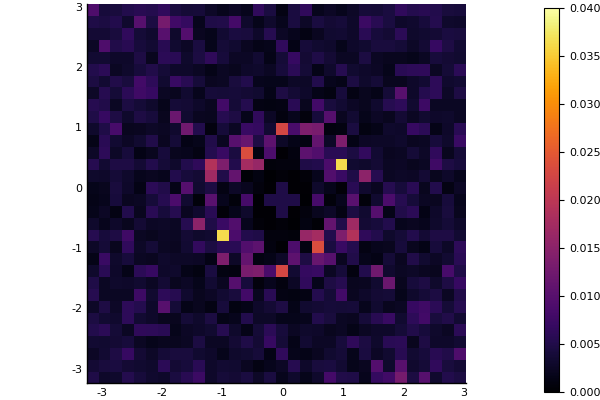

In [22]:
# Finding if there is correct normalization
S⁺_avg = mean(S⁺_by_T[rand(1:N_T)]);
println(maximum(S⁺_avg))
clim_max = 0.04
heatmap(kx, ky, removeMiddle(S⁺_avg); aspect_ratio=1.0, clims=(0,clim_max))

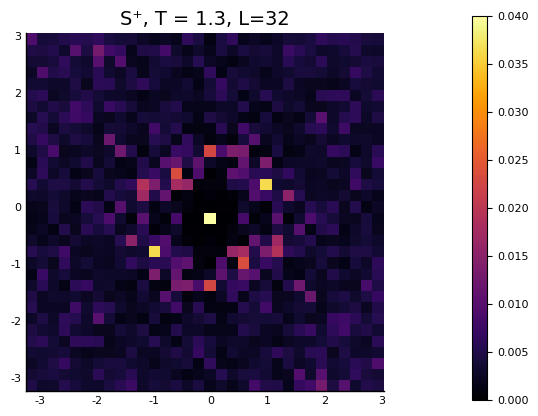

In [23]:
mkcd("S+")
for k = 1:N_T
    T = round(temps[k]; digits=2)
    S⁺_avg = mean(S⁺_by_T[k])
    plt = heatmap(kx, ky, S⁺_avg; aspect_ratio=1.0, title="S⁺, T = $(T), L=$(L₁)", clims=(0, clim_max))
    savefig(plt, "S+_avg_T=$(T)")
end
cd("../")

In [24]:
S⁻_by_T = vo_di["sm"];
println("Measures $(length(S⁻_by_T[1]))")
println("Maximum: $(maximum(S⁻_by_T[rand(1:N_T)][rand(1:M)])/(L₁*L₂*f*two_pi)^2)")
# Normalizing structure function
normalization = (L₁*L₂*f*two_pi)^2
S⁻_by_T = [S⁻_measures./normalization for S⁻_measures in S⁻_by_T];

Measures 8192
Maximum: 1.000000000000001


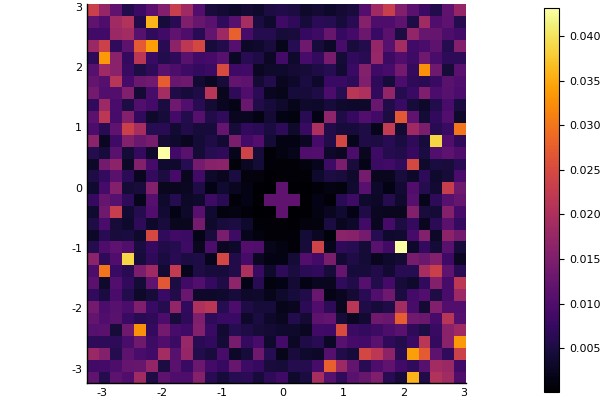

In [25]:
int = 1:M
S⁻_avg = mean(S⁻_by_T[1][int])
heatmap(kx, ky, removeMiddle(S⁻_avg); aspect_ratio=1.0)

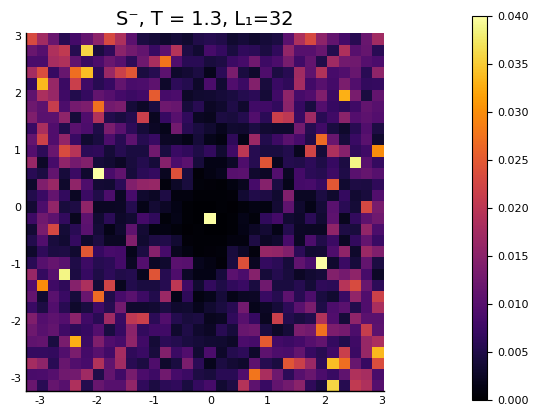

In [26]:
mkcd("S-")
for k = 1:N_T
    T = round(temps[k]; digits=2)
    S⁻_avg = mean(S⁻_by_T[k])
    plt = heatmap(kx, ky, S⁻_avg; aspect_ratio=1.0, title="S⁻, T = $(T), L₁=$(L₁)", clims=(0, clim_max))
    savefig(plt, "S-_avg_T=$(T)")
end
cd("../")

#### Vorticity

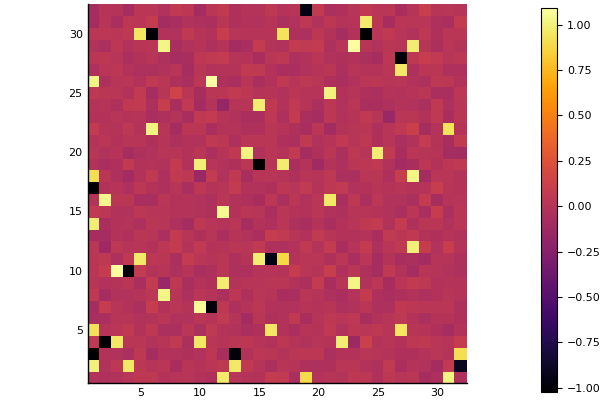

In [27]:
vortices_by_T = vo_di["vortexes"];
V⁺_by_T = [vortices_by_T[k][1] for k = 1:N_T]
V⁻_by_T = [vortices_by_T[k][2] for k = 1:N_T]
mkcd("V+")
cd("../")
mkcd("V-")
cd("../")
heatmap(V⁺_by_T[rand(1:N_T)][:,:,rand(1:L₃)]./two_pi; aspect_ratio=1.0)

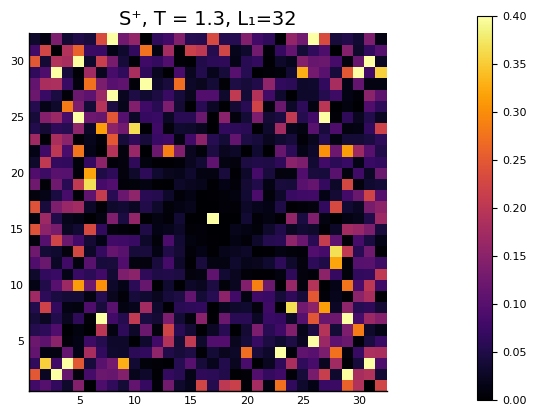

In [28]:
for k = 1:N_T
    layer = rand(1:L₃)
    V⁺ = V⁺_by_T[k][:,:,layer]./two_pi
    V⁻ = V⁻_by_T[k][:,:,layer]./two_pi
    S⁺, S⁻ = structureFunction(V⁺, V⁻)
    normalization = (L₁*L₂*f)^2
    S⁺ /= normalization; S⁻ /= normalization
    temp = round(temps[k], digits=2)
    plt⁺ = heatmap(V⁺; aspect_ratio=1.0, clims=(-1, 1), title="V⁺, z=$(layer), T=$(temp)")
    plt⁻ = heatmap(V⁻; aspect_ratio=1.0, clims=(-1, 1), title="V⁻, z=$(layer), T=$(temp)")
    savefig(plt⁺, "V+/V+_snap_T=$(temp).png")
    savefig(plt⁻, "V-/V-_snap_T=$(temp).png")
    
    # Saving corresponding fourier transforms
    plt_S⁻ = heatmap(S⁻; aspect_ratio=1.0, title="S⁻, T = $(temp), L₁=$(L₁)", clims=(0, 0.4))
    savefig(plt_S⁻, "V-/S-_snap_T=$(temp)")
    plt_S⁺ = heatmap(S⁺; aspect_ratio=1.0, title="S⁺, T = $(temp), L₁=$(L₁)", clims=(0, 0.4))
    savefig(plt_S⁺, "V+/S+_snap_T=$(temp)")
end

#### Structure factor progression

In [29]:
cooldown_di = JLD.load("cooldown.jld");
M_pr_step = cooldown_di["M_pr_step"]
N_steps = cooldown_di["N_steps"]
M_col = M_pr_step*N_steps
M_est = cooldown_di["M_est"]
S⁺_col_by_T = cooldown_di["sp"];
E_col_matrix = cooldown_di["E_matrix"]
temp_col_matrix = cooldown_di["temp_matrix"]
println("Steps pr. temp.: $(steps = length(S⁺_col_by_T[1]))")
println("Maximum: $(maximum(S⁺_col_by_T[rand(1:N_T)][rand(1:steps)])/(L₁*L₂*f*two_pi)^2)")
normalization = (L₁*L₂*f*two_pi)^2
S⁺_col_by_T = [S⁺_steps./normalization for S⁺_steps in S⁺_col_by_T];

Steps pr. temp.: 1024
Maximum: 1.0000000000000053


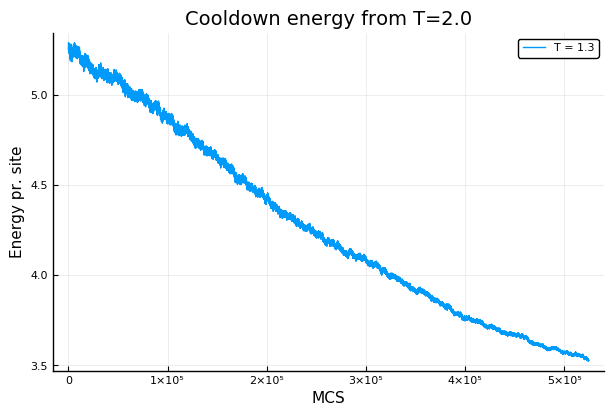

In [30]:
int = 1:M_col+1#floor(Int64, M_th/2)
therm_plt = plot(collect(int).+M_est, [E_col_matrix[int, i] for i = 1:N_T]; 
                 label=reshape(["T = $(round(T; digits=2))" for T in temps], (1, N_T)),
                 xaxis="MCS", yaxis="Energy pr. site", title="Cooldown energy from T=$(temp_col_matrix[1,1])")
savefig(therm_plt, "cooldown energies.pdf")

# TODO: plot acceptance rate

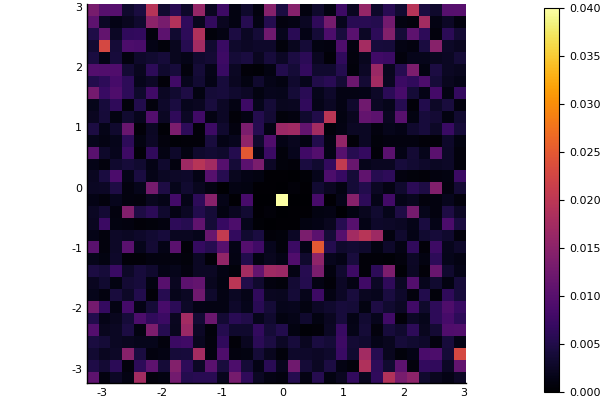

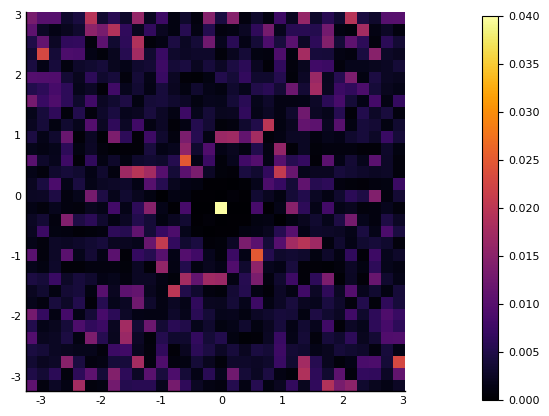

In [33]:
for k = 1:N_T
    S⁺_test = S⁺_col_by_T[k][end]
    display(heatmap(kx, ky, S⁺_test; aspect_ratio=1.0, clims=(0,clim_max)))
end

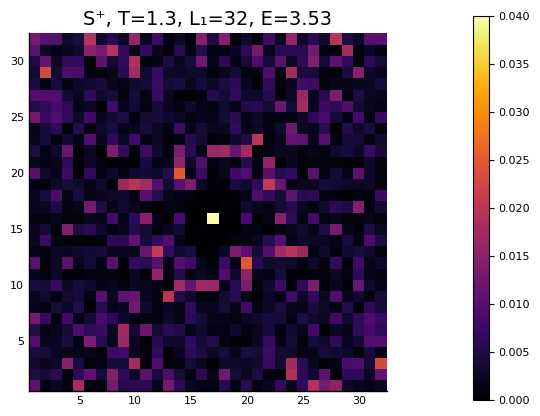

In [32]:
mkcd("S+_progress")
for k = 1:N_T
    T = round(temps[k]; digits=2)
    mkcd("T=$(T)")
    S⁺_steps = S⁺_col_by_T[k]
    steps = length(S⁺_steps)
    
    for s = 1:steps
        S⁺_step = S⁺_steps[s]
        plt = heatmap(S⁺_step; aspect_ratio=1.0, clims=(0, clim_max), title="S⁺, T=$(round(temp_col_matrix[s, k]; digits=2)), L₁=$(L₁), E=$(round(E_col_matrix[(s-1)*M_pr_step+1]; digits=2))")
        savefig(plt, "step=$(lpad(s,4,'0')).png")
    end
    
    cd("../")
end
cd("../")

# Amplitude measurements

In [34]:
amplitude_di = JLD.load("amplitudes.jld")

Dict{String,Any} with 4 entries:
  "um_lattices" => Array{Array{Float64,3},1}[[[0.990812 0.948758 … 0.999333 0.8…
  "um_xy"       => Array{Float64,2}[[5261.38 5424.22 … 4682.87 5456.24; 4716.91…
  "up_lattices" => Array{Array{Float64,3},1}[[[0.135247 0.316003 … 0.0365165 0.…
  "up_xy"       => Array{Float64,2}[[5121.57 5050.97 … 5639.35 4992.3; 5594.97 …

In [35]:
u⁻_lattices = amplitude_di["um_lattices"];
u⁺_lattices = amplitude_di["up_lattices"];
u⁻_avg_lattices = amplitude_di["um_xy"];
u⁺_avg_lattices = amplitude_di["up_xy"];

In [36]:
mkcd("Amplitudes")

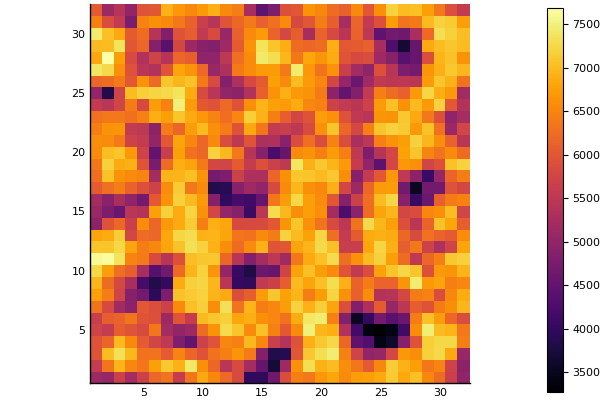

In [37]:
heatmap(u⁺_avg_lattices[1]; aspect_ratio=1.0)

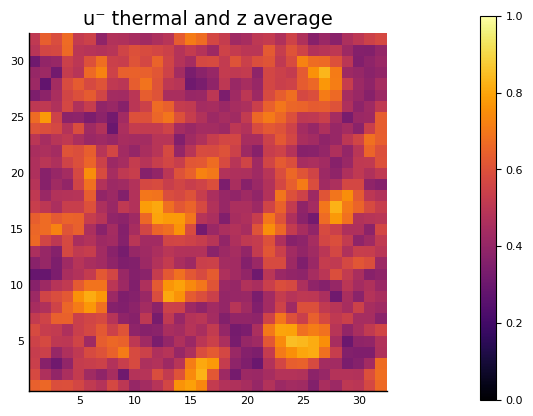

In [38]:
for k = 1:N_T
    u⁺_avg = u⁺_avg_lattices[k]./M
    u⁻_avg = u⁻_avg_lattices[k]./M
    plt = heatmap(u⁺_avg; aspect_ratio=1.0, clims=(0, 1), title="u⁺ thermal and z average")
    savefig(plt, "u⁺_average.png")
    plt = heatmap(u⁻_avg; aspect_ratio=1.0, clims=(0, 1), title="u⁻ thermal and z average")
    savefig(plt, "u⁻_average.png")
end

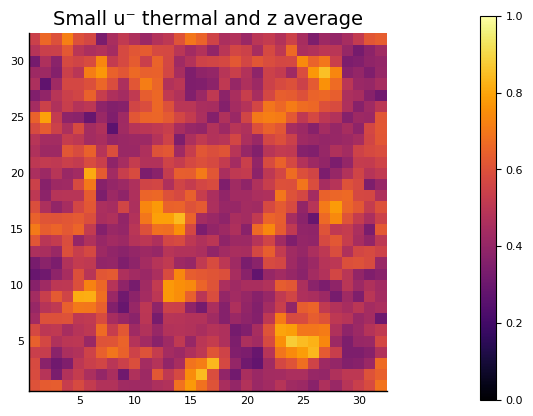

In [39]:
for k = 1:N_T
    u⁻_lattice_meas = u⁻_lattices[k]
    u⁺_lattice_meas = u⁺_lattices[k]
    u⁻_xy_snapshot = u⁻_lattice_meas[end][:,:,1]
    u⁺_xy_snapshot = u⁺_lattice_meas[end][:,:,1]
    plt = heatmap(u⁻_xy_snapshot; aspect_ratio=1.0, clims=(0, 1), title="u⁻ snapshot of layer z=1")
    savefig(plt, "u⁻_snapshot.png")
    plt = heatmap(u⁺_xy_snapshot; aspect_ratio=1.0, clims=(0, 1), title="u⁺ snapshot of layer z=1")
    savefig(plt, "u⁺_snapshot.png")
    u⁺_layer_avg = u⁺_lattice_meas[1][:,:,1]
    u⁻_layer_avg = u⁻_lattice_meas[1][:,:,1]
    u⁺_small_avg = mean([u⁺_lattice_meas[1][:,:,l] for l = 1:size(u⁺_lattice_meas[1],3)])
    u⁻_small_avg = mean([u⁻_lattice_meas[1][:,:,l] for l = 1:size(u⁻_lattice_meas[1],3)])
    for m = 2:M_amp
        u⁺_layer_avg .+= u⁺_lattice_meas[m][:,:,1]
        u⁻_layer_avg .+= u⁻_lattice_meas[m][:,:,1]
        u⁺_small_avg .+= mean([u⁺_lattice_meas[m][:,:,l] for l = 1:size(u⁺_lattice_meas[1],3)])
        u⁻_small_avg .+= mean([u⁻_lattice_meas[m][:,:,l] for l = 1:size(u⁻_lattice_meas[1],3)])
    end
    u⁺_layer_avg ./= M_amp; u⁻_layer_avg ./= M_amp
    u⁺_small_avg ./= M_amp; u⁻_small_avg ./= M_amp
    plt = heatmap(u⁺_layer_avg; aspect_ratio=1.0, clims=(0,1), title="Layer z = 1 avg of u⁺")
    savefig(plt, "u⁺_avg_layer_z=1.png")
    plt = heatmap(u⁻_layer_avg; aspect_ratio=1.0, clims=(0,1), title="Layer z = 1 avg of u⁻")
    savefig(plt, "u⁻_avg_layer_z=1.png")
    plt = heatmap(u⁺_small_avg; aspect_ratio=1.0, clims=(0,1), title="Small u⁺ thermal and z average")
    savefig(plt, "u⁺_small_avg.png")
    plt = heatmap(u⁻_small_avg; aspect_ratio=1.0, clims=(0,1), title="Small u⁻ thermal and z average")
    savefig(plt, "u⁻_small_avg.png")
end

In [45]:
cd("../")